# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

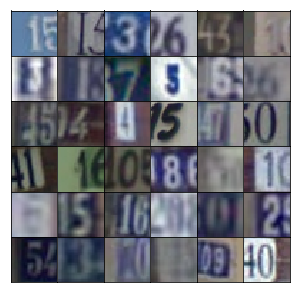

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3. 

>**Exercise:** Build the transposed convolutional network for the generator in the function below. Be sure to use leaky ReLUs on all the layers except for the last tanh layer, as well as batch normalization on all the transposed convolutional layers except the last one.

In [9]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x = tf.layers.dense(z, 4*4*512, activation=None)
        
        x = tf.reshape(x, shape=[-1, 4, 4, 512])
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(alpha * x, x)
        # 4x4x512 now
        
        conv1 = tf.layers.conv2d_transpose(x, 256, (5,5), (2,2), padding='same', activation=None)
        conv1 = tf.layers.batch_normalization(conv1, training=training)
        conv1 = tf.maximum(alpha * conv1, conv1)
        # 8x8x256 now
        
        conv2 = tf.layers.conv2d_transpose(conv1, 128, (5,5), (2,2), padding='same', activation=None)
        conv2 = tf.layers.batch_normalization(conv2, training=training)
        conv2 = tf.maximum(alpha * conv2, conv2)
        # 16x16x128 now
        
        # Output layer, 32x32x3
        logits = tf.layers.conv2d_transpose(conv2, 3, (5,5), (2,2), padding='same', activation=None)
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU.

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

>**Exercise:** Build the convolutional network for the discriminator. The input is a 32x32x3 images, the output is a sigmoid plus the logits. Again, use Leaky ReLU activations and batch normalization on all the layers except the first.

In [10]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x = tf.layers.conv2d(x, 64, (5,5), (2,2), padding='same', activation=None)
        # x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 16x16x64 now
        
        x = tf.layers.conv2d(x, 128, (5,5), (2,2), padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 8x8x128 now
        
        x = tf.layers.conv2d(x, 256, (5,5), (2,2), padding='same', activation=None)
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(alpha * x, x)
        # 4x4x256 now
        
        flat = tf.reshape(x, [-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Calculating the loss like before, nothing new here.

In [11]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [13]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=0.2)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

Here is a function for displaying generated images.

In [14]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an errror without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [15]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very senstive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

>**Exercise:** Find hyperparameters to train this GAN. The values found in the DCGAN paper work well, or you can experiment on your own. In general, you want the discriminator loss to be around 0.3, this means it is correctly classifying images as fake or real about 50% of the time.

In [ ]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 10
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Epoch 1/10... Discriminator Loss: 0.9187... Generator Loss: 1.0224
Epoch 1/10... Discriminator Loss: 0.5057... Generator Loss: 1.5364
Epoch 1/10... Discriminator Loss: 0.1358... Generator Loss: 5.3330
Epoch 1/10... Discriminator Loss: 0.1380... Generator Loss: 2.5717
Epoch 1/10... Discriminator Loss: 0.1536... Generator Loss: 2.8135
Epoch 1/10... Discriminator Loss: 0.2255... Generator Loss: 2.1472
Epoch 1/10... Discriminator Loss: 0.1148... Generator Loss: 2.9072
Epoch 1/10... Discriminator Loss: 0.1489... Generator Loss: 2.9577
Epoch 1/10... Discriminator Loss: 0.0892... Generator Loss: 3.4171
Epoch 1/10... Discriminator Loss: 0.1445... Generator Loss: 3.0432


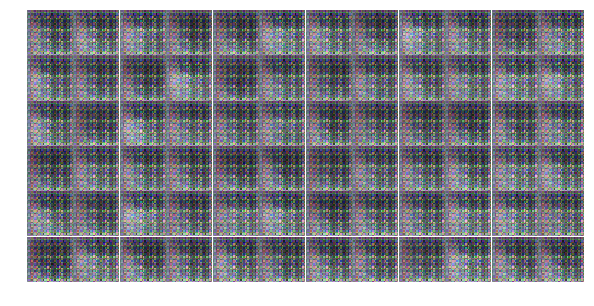

Epoch 1/10... Discriminator Loss: 0.3240... Generator Loss: 2.5420
Epoch 1/10... Discriminator Loss: 0.7269... Generator Loss: 1.6042
Epoch 1/10... Discriminator Loss: 0.6764... Generator Loss: 1.4526
Epoch 1/10... Discriminator Loss: 0.4050... Generator Loss: 2.2306
Epoch 1/10... Discriminator Loss: 0.4575... Generator Loss: 1.5179
Epoch 1/10... Discriminator Loss: 0.4489... Generator Loss: 2.7019
Epoch 1/10... Discriminator Loss: 0.2287... Generator Loss: 2.5587
Epoch 1/10... Discriminator Loss: 0.2907... Generator Loss: 3.3048
Epoch 1/10... Discriminator Loss: 0.5333... Generator Loss: 1.2376
Epoch 1/10... Discriminator Loss: 0.5246... Generator Loss: 2.8990


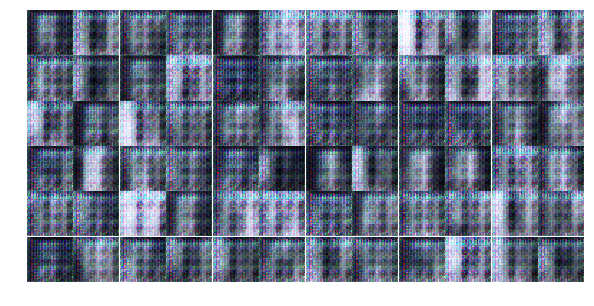

Epoch 1/10... Discriminator Loss: 0.2471... Generator Loss: 2.3051
Epoch 1/10... Discriminator Loss: 1.5815... Generator Loss: 0.4539
Epoch 1/10... Discriminator Loss: 0.6816... Generator Loss: 2.1269
Epoch 1/10... Discriminator Loss: 0.1104... Generator Loss: 4.2652
Epoch 1/10... Discriminator Loss: 0.6414... Generator Loss: 1.1904
Epoch 1/10... Discriminator Loss: 0.4177... Generator Loss: 3.5260
Epoch 1/10... Discriminator Loss: 0.5478... Generator Loss: 1.2619
Epoch 1/10... Discriminator Loss: 0.2116... Generator Loss: 3.8135
Epoch 1/10... Discriminator Loss: 0.7221... Generator Loss: 5.5050
Epoch 1/10... Discriminator Loss: 0.6694... Generator Loss: 1.5260


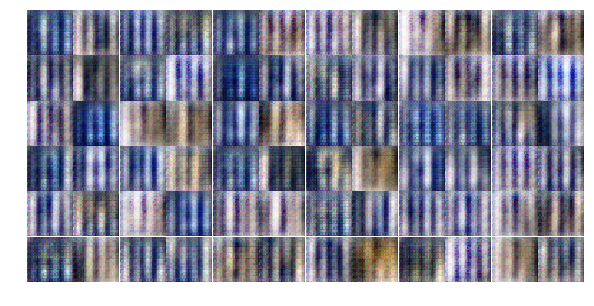

Epoch 1/10... Discriminator Loss: 0.6464... Generator Loss: 1.9427
Epoch 1/10... Discriminator Loss: 0.2745... Generator Loss: 2.9001
Epoch 1/10... Discriminator Loss: 0.2389... Generator Loss: 2.7783
Epoch 1/10... Discriminator Loss: 0.7427... Generator Loss: 4.7361
Epoch 1/10... Discriminator Loss: 0.4146... Generator Loss: 2.4231
Epoch 1/10... Discriminator Loss: 0.7092... Generator Loss: 0.9836
Epoch 1/10... Discriminator Loss: 0.9076... Generator Loss: 0.6782
Epoch 1/10... Discriminator Loss: 0.7535... Generator Loss: 2.3618
Epoch 1/10... Discriminator Loss: 0.9375... Generator Loss: 1.7746
Epoch 1/10... Discriminator Loss: 0.3713... Generator Loss: 1.8664


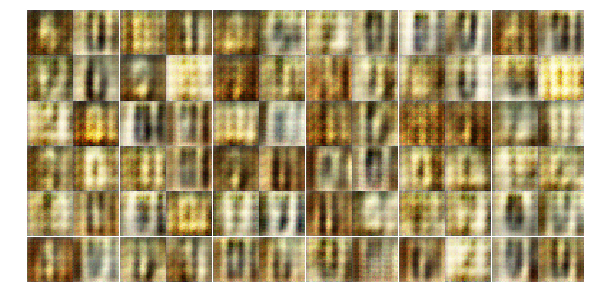

Epoch 1/10... Discriminator Loss: 0.3522... Generator Loss: 1.8975
Epoch 1/10... Discriminator Loss: 0.2910... Generator Loss: 2.9479
Epoch 1/10... Discriminator Loss: 0.4465... Generator Loss: 1.6506
Epoch 1/10... Discriminator Loss: 0.6205... Generator Loss: 1.6214
Epoch 1/10... Discriminator Loss: 0.7277... Generator Loss: 2.0572
Epoch 1/10... Discriminator Loss: 1.0649... Generator Loss: 0.6641
Epoch 1/10... Discriminator Loss: 0.2736... Generator Loss: 3.0047
Epoch 1/10... Discriminator Loss: 0.7315... Generator Loss: 1.2665
Epoch 1/10... Discriminator Loss: 0.5455... Generator Loss: 1.4733
Epoch 1/10... Discriminator Loss: 0.7315... Generator Loss: 1.4095


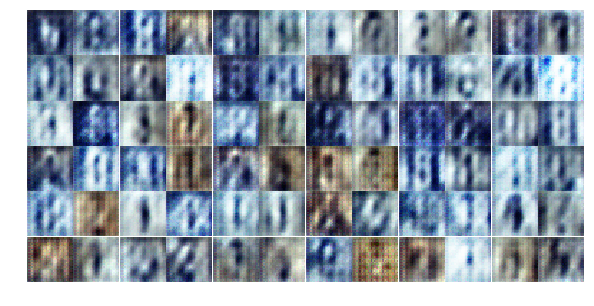

Epoch 1/10... Discriminator Loss: 0.6222... Generator Loss: 1.6556
Epoch 1/10... Discriminator Loss: 0.6801... Generator Loss: 1.1960
Epoch 1/10... Discriminator Loss: 0.5645... Generator Loss: 1.6323
Epoch 1/10... Discriminator Loss: 0.8442... Generator Loss: 0.8897
Epoch 1/10... Discriminator Loss: 0.6649... Generator Loss: 2.3829
Epoch 1/10... Discriminator Loss: 0.5266... Generator Loss: 1.7358
Epoch 1/10... Discriminator Loss: 0.5985... Generator Loss: 1.4457
Epoch 2/10... Discriminator Loss: 0.7797... Generator Loss: 1.3366
Epoch 2/10... Discriminator Loss: 0.6427... Generator Loss: 2.0791
Epoch 2/10... Discriminator Loss: 0.6157... Generator Loss: 1.3021


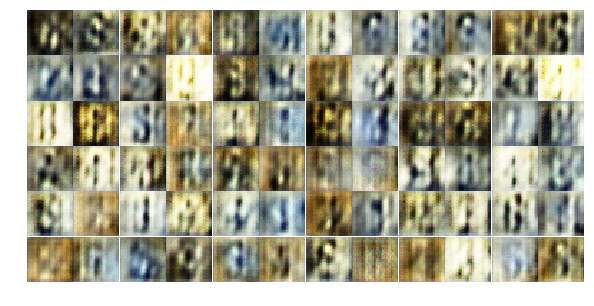

Epoch 2/10... Discriminator Loss: 0.8104... Generator Loss: 1.4513
Epoch 2/10... Discriminator Loss: 0.7702... Generator Loss: 1.9651
Epoch 2/10... Discriminator Loss: 0.6776... Generator Loss: 1.5269
Epoch 2/10... Discriminator Loss: 0.5439... Generator Loss: 1.5093
Epoch 2/10... Discriminator Loss: 0.9343... Generator Loss: 0.9755
Epoch 2/10... Discriminator Loss: 1.0686... Generator Loss: 1.9380
Epoch 2/10... Discriminator Loss: 1.1149... Generator Loss: 0.8719
Epoch 2/10... Discriminator Loss: 1.6405... Generator Loss: 1.4333
Epoch 2/10... Discriminator Loss: 0.8944... Generator Loss: 0.9124
Epoch 2/10... Discriminator Loss: 1.0460... Generator Loss: 1.4371


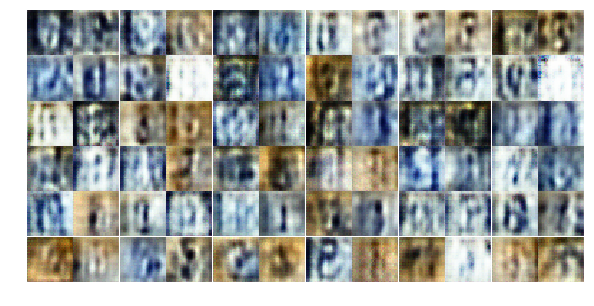

Epoch 2/10... Discriminator Loss: 1.0467... Generator Loss: 1.2373
Epoch 2/10... Discriminator Loss: 1.2331... Generator Loss: 1.0849
Epoch 2/10... Discriminator Loss: 0.7260... Generator Loss: 1.7464
Epoch 2/10... Discriminator Loss: 0.7992... Generator Loss: 1.0560
Epoch 2/10... Discriminator Loss: 1.1691... Generator Loss: 1.2749
Epoch 2/10... Discriminator Loss: 1.1556... Generator Loss: 0.8247
Epoch 2/10... Discriminator Loss: 1.3016... Generator Loss: 0.7490
Epoch 2/10... Discriminator Loss: 1.1629... Generator Loss: 0.8646
Epoch 2/10... Discriminator Loss: 0.7432... Generator Loss: 1.2723
Epoch 2/10... Discriminator Loss: 1.6991... Generator Loss: 0.4733


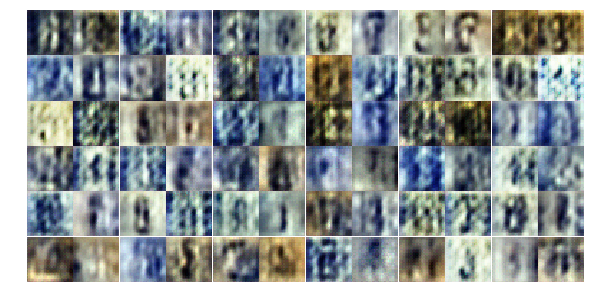

Epoch 2/10... Discriminator Loss: 0.8531... Generator Loss: 1.0494
Epoch 2/10... Discriminator Loss: 1.0858... Generator Loss: 1.0664
Epoch 2/10... Discriminator Loss: 0.9842... Generator Loss: 1.3651
Epoch 2/10... Discriminator Loss: 0.8825... Generator Loss: 1.1758
Epoch 2/10... Discriminator Loss: 0.8808... Generator Loss: 1.2225
Epoch 2/10... Discriminator Loss: 0.9685... Generator Loss: 0.9528
Epoch 2/10... Discriminator Loss: 1.0164... Generator Loss: 0.9443
Epoch 2/10... Discriminator Loss: 1.1054... Generator Loss: 0.7335
Epoch 2/10... Discriminator Loss: 1.0212... Generator Loss: 0.9251
Epoch 2/10... Discriminator Loss: 0.8946... Generator Loss: 1.0273


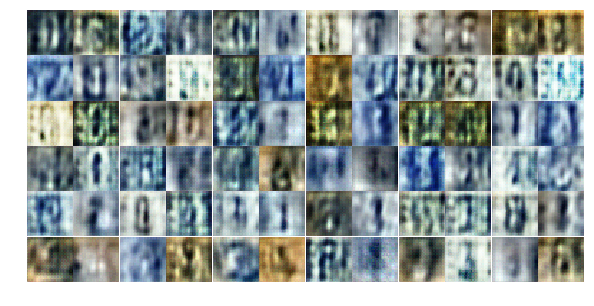

Epoch 2/10... Discriminator Loss: 1.0709... Generator Loss: 0.8453
Epoch 2/10... Discriminator Loss: 1.2308... Generator Loss: 0.8550
Epoch 2/10... Discriminator Loss: 1.0983... Generator Loss: 0.7232
Epoch 2/10... Discriminator Loss: 1.3020... Generator Loss: 0.6922
Epoch 2/10... Discriminator Loss: 1.0743... Generator Loss: 1.2134
Epoch 2/10... Discriminator Loss: 1.2401... Generator Loss: 1.0505
Epoch 2/10... Discriminator Loss: 1.2978... Generator Loss: 1.0089
Epoch 2/10... Discriminator Loss: 0.9429... Generator Loss: 1.1471
Epoch 2/10... Discriminator Loss: 1.1141... Generator Loss: 1.3433
Epoch 2/10... Discriminator Loss: 0.9798... Generator Loss: 1.1362


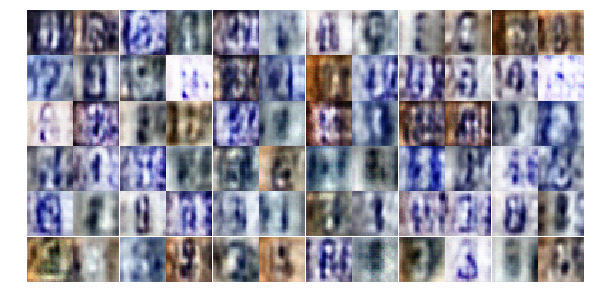

Epoch 2/10... Discriminator Loss: 0.9351... Generator Loss: 1.0769
Epoch 2/10... Discriminator Loss: 0.9813... Generator Loss: 1.0982
Epoch 2/10... Discriminator Loss: 0.9034... Generator Loss: 0.9114
Epoch 2/10... Discriminator Loss: 1.5201... Generator Loss: 0.4546
Epoch 2/10... Discriminator Loss: 0.9290... Generator Loss: 1.0329
Epoch 2/10... Discriminator Loss: 1.3181... Generator Loss: 0.6380
Epoch 2/10... Discriminator Loss: 1.0215... Generator Loss: 1.1359
Epoch 2/10... Discriminator Loss: 1.0642... Generator Loss: 0.8390
Epoch 2/10... Discriminator Loss: 0.7875... Generator Loss: 1.2502
Epoch 2/10... Discriminator Loss: 0.9275... Generator Loss: 1.1700


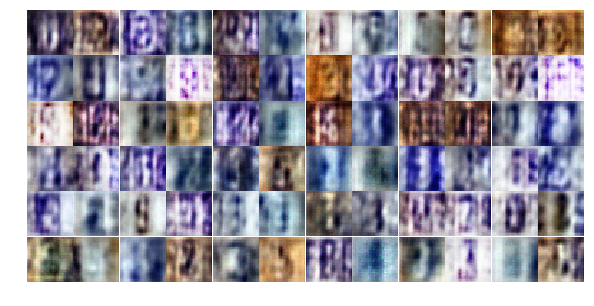

Epoch 2/10... Discriminator Loss: 0.9183... Generator Loss: 1.4420
Epoch 2/10... Discriminator Loss: 0.8750... Generator Loss: 1.3193
Epoch 2/10... Discriminator Loss: 1.1561... Generator Loss: 0.7125
Epoch 2/10... Discriminator Loss: 1.1208... Generator Loss: 0.7310
Epoch 3/10... Discriminator Loss: 0.9404... Generator Loss: 1.6634
Epoch 3/10... Discriminator Loss: 0.8602... Generator Loss: 1.0361
Epoch 3/10... Discriminator Loss: 1.0544... Generator Loss: 1.4523
Epoch 3/10... Discriminator Loss: 0.8207... Generator Loss: 1.0471
Epoch 3/10... Discriminator Loss: 0.8635... Generator Loss: 0.9170
Epoch 3/10... Discriminator Loss: 0.9237... Generator Loss: 1.0464


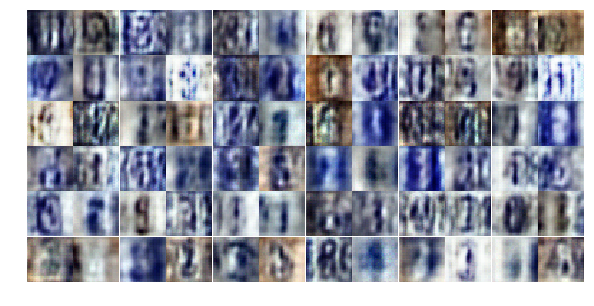

Epoch 3/10... Discriminator Loss: 0.9986... Generator Loss: 0.8317
Epoch 3/10... Discriminator Loss: 0.9108... Generator Loss: 1.0246
Epoch 3/10... Discriminator Loss: 0.9898... Generator Loss: 0.8799
Epoch 3/10... Discriminator Loss: 0.7499... Generator Loss: 1.6066
Epoch 3/10... Discriminator Loss: 1.0864... Generator Loss: 0.9476
Epoch 3/10... Discriminator Loss: 0.7841... Generator Loss: 1.0449
Epoch 3/10... Discriminator Loss: 0.9061... Generator Loss: 1.9727
Epoch 3/10... Discriminator Loss: 1.1244... Generator Loss: 1.1321
Epoch 3/10... Discriminator Loss: 0.6289... Generator Loss: 1.4774
Epoch 3/10... Discriminator Loss: 0.8369... Generator Loss: 1.1454


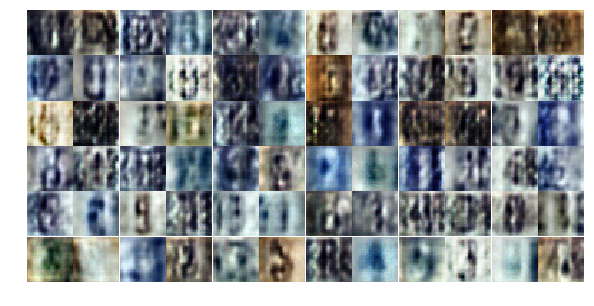

Epoch 3/10... Discriminator Loss: 0.9088... Generator Loss: 1.3042
Epoch 3/10... Discriminator Loss: 0.7614... Generator Loss: 1.3222
Epoch 3/10... Discriminator Loss: 0.5623... Generator Loss: 1.5238
Epoch 3/10... Discriminator Loss: 0.6171... Generator Loss: 1.2970
Epoch 3/10... Discriminator Loss: 0.6552... Generator Loss: 1.3864
Epoch 3/10... Discriminator Loss: 0.6556... Generator Loss: 1.2783
Epoch 3/10... Discriminator Loss: 0.7215... Generator Loss: 1.1645
Epoch 3/10... Discriminator Loss: 0.6670... Generator Loss: 1.2066
Epoch 3/10... Discriminator Loss: 0.4982... Generator Loss: 1.6875
Epoch 3/10... Discriminator Loss: 0.4823... Generator Loss: 1.4734


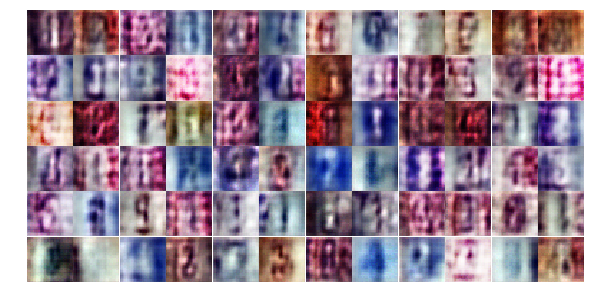

Epoch 3/10... Discriminator Loss: 0.7261... Generator Loss: 1.3103
Epoch 3/10... Discriminator Loss: 1.0120... Generator Loss: 0.6675
Epoch 3/10... Discriminator Loss: 0.6389... Generator Loss: 1.2740
Epoch 3/10... Discriminator Loss: 0.7222... Generator Loss: 0.9318
Epoch 3/10... Discriminator Loss: 0.6672... Generator Loss: 1.2227
Epoch 3/10... Discriminator Loss: 0.6867... Generator Loss: 1.1306
Epoch 3/10... Discriminator Loss: 0.8123... Generator Loss: 0.9892
Epoch 3/10... Discriminator Loss: 0.6940... Generator Loss: 1.2966
Epoch 3/10... Discriminator Loss: 0.5678... Generator Loss: 1.2599
Epoch 3/10... Discriminator Loss: 0.5764... Generator Loss: 1.2272


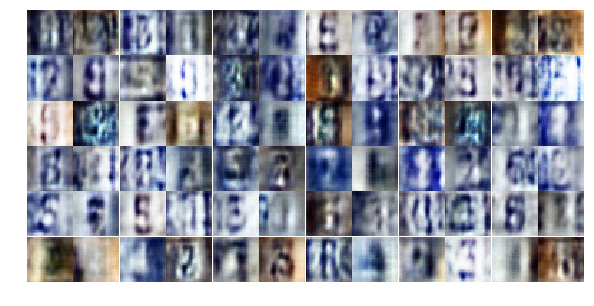

Epoch 3/10... Discriminator Loss: 0.4334... Generator Loss: 1.8742
Epoch 3/10... Discriminator Loss: 0.5435... Generator Loss: 1.3915
Epoch 3/10... Discriminator Loss: 0.4843... Generator Loss: 1.5472
Epoch 3/10... Discriminator Loss: 0.4957... Generator Loss: 1.3624
Epoch 3/10... Discriminator Loss: 0.6384... Generator Loss: 2.7254
Epoch 3/10... Discriminator Loss: 0.6164... Generator Loss: 1.1948
Epoch 3/10... Discriminator Loss: 0.9751... Generator Loss: 0.7644
Epoch 3/10... Discriminator Loss: 0.7039... Generator Loss: 1.1374
Epoch 3/10... Discriminator Loss: 1.4483... Generator Loss: 0.4408
Epoch 3/10... Discriminator Loss: 0.7416... Generator Loss: 1.2510


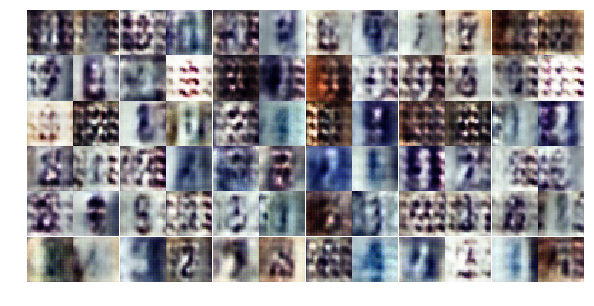

Epoch 3/10... Discriminator Loss: 0.9722... Generator Loss: 0.9419
Epoch 3/10... Discriminator Loss: 0.5947... Generator Loss: 1.9356
Epoch 3/10... Discriminator Loss: 1.0592... Generator Loss: 0.5696
Epoch 3/10... Discriminator Loss: 0.5294... Generator Loss: 1.9311
Epoch 3/10... Discriminator Loss: 0.7650... Generator Loss: 1.0264
Epoch 3/10... Discriminator Loss: 0.4216... Generator Loss: 1.7285
Epoch 3/10... Discriminator Loss: 0.2886... Generator Loss: 2.1390
Epoch 3/10... Discriminator Loss: 0.4167... Generator Loss: 2.5828
Epoch 3/10... Discriminator Loss: 0.4747... Generator Loss: 1.9098
Epoch 3/10... Discriminator Loss: 0.3863... Generator Loss: 1.9281


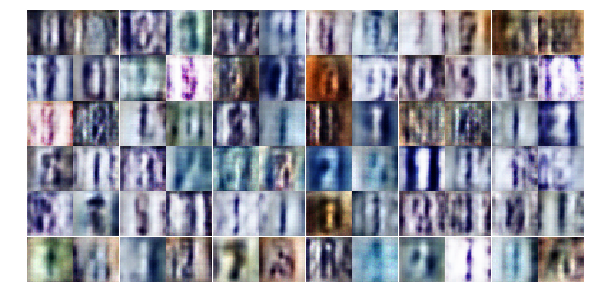

Epoch 3/10... Discriminator Loss: 0.5505... Generator Loss: 1.1411
Epoch 4/10... Discriminator Loss: 1.2078... Generator Loss: 0.4775
Epoch 4/10... Discriminator Loss: 0.7271... Generator Loss: 1.3138
Epoch 4/10... Discriminator Loss: 0.4982... Generator Loss: 1.3272
Epoch 4/10... Discriminator Loss: 0.4190... Generator Loss: 1.7707
Epoch 4/10... Discriminator Loss: 0.5042... Generator Loss: 1.4124
Epoch 4/10... Discriminator Loss: 0.6147... Generator Loss: 1.6284
Epoch 4/10... Discriminator Loss: 0.7060... Generator Loss: 1.0668
Epoch 4/10... Discriminator Loss: 0.5202... Generator Loss: 1.2367
Epoch 4/10... Discriminator Loss: 0.9062... Generator Loss: 0.7086


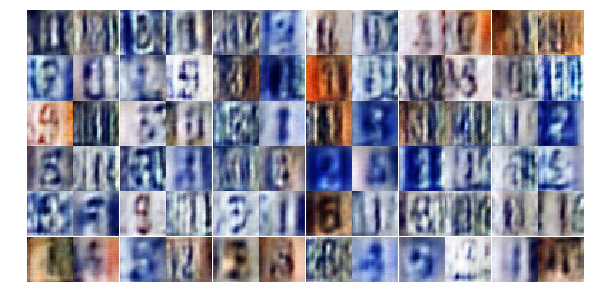

Epoch 4/10... Discriminator Loss: 0.5300... Generator Loss: 1.4047
Epoch 4/10... Discriminator Loss: 0.8404... Generator Loss: 0.8036
Epoch 4/10... Discriminator Loss: 0.7629... Generator Loss: 1.1646
Epoch 4/10... Discriminator Loss: 0.5582... Generator Loss: 1.6168
Epoch 4/10... Discriminator Loss: 0.6389... Generator Loss: 1.7825
Epoch 4/10... Discriminator Loss: 0.8537... Generator Loss: 0.8935
Epoch 4/10... Discriminator Loss: 0.5667... Generator Loss: 1.1253
Epoch 4/10... Discriminator Loss: 0.5469... Generator Loss: 1.8190
Epoch 4/10... Discriminator Loss: 0.7921... Generator Loss: 2.4706
Epoch 4/10... Discriminator Loss: 0.5410... Generator Loss: 1.4937


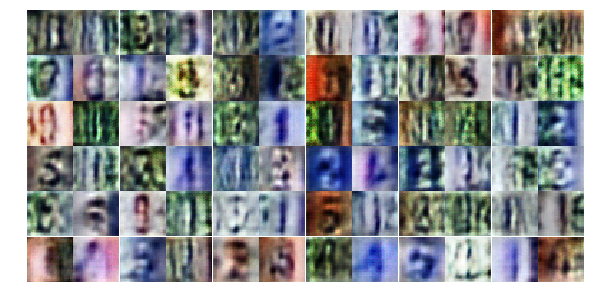

Epoch 4/10... Discriminator Loss: 0.7169... Generator Loss: 1.5150
Epoch 4/10... Discriminator Loss: 0.7713... Generator Loss: 2.2810
Epoch 4/10... Discriminator Loss: 1.0703... Generator Loss: 0.6014
Epoch 4/10... Discriminator Loss: 0.4637... Generator Loss: 1.6810
Epoch 4/10... Discriminator Loss: 0.4399... Generator Loss: 1.6371
Epoch 4/10... Discriminator Loss: 0.6206... Generator Loss: 2.2992
Epoch 4/10... Discriminator Loss: 1.6607... Generator Loss: 0.3412
Epoch 4/10... Discriminator Loss: 1.0630... Generator Loss: 0.5309
Epoch 4/10... Discriminator Loss: 0.6256... Generator Loss: 1.1662
Epoch 4/10... Discriminator Loss: 0.6397... Generator Loss: 1.7343


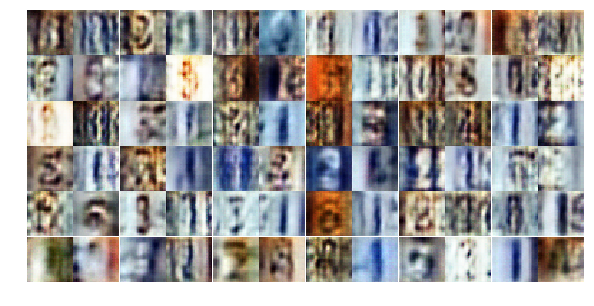

Epoch 4/10... Discriminator Loss: 0.5194... Generator Loss: 1.4839
Epoch 4/10... Discriminator Loss: 0.7553... Generator Loss: 1.0358
Epoch 4/10... Discriminator Loss: 0.6914... Generator Loss: 1.0782
Epoch 4/10... Discriminator Loss: 0.4323... Generator Loss: 1.6932
Epoch 4/10... Discriminator Loss: 0.3573... Generator Loss: 1.9967
Epoch 4/10... Discriminator Loss: 0.3506... Generator Loss: 1.9870
Epoch 4/10... Discriminator Loss: 0.5507... Generator Loss: 2.0087
Epoch 4/10... Discriminator Loss: 0.9100... Generator Loss: 0.7447
Epoch 4/10... Discriminator Loss: 0.7878... Generator Loss: 0.8566
Epoch 4/10... Discriminator Loss: 0.5712... Generator Loss: 1.1828


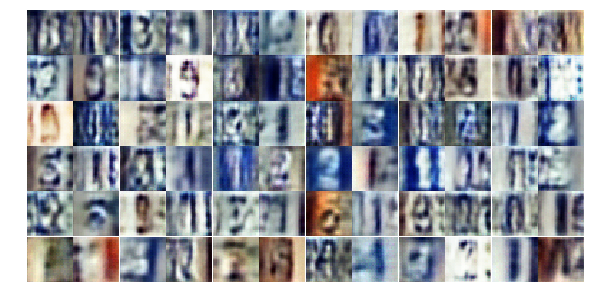

Epoch 4/10... Discriminator Loss: 0.4241... Generator Loss: 2.1179
Epoch 4/10... Discriminator Loss: 0.3692... Generator Loss: 1.8717
Epoch 4/10... Discriminator Loss: 0.5411... Generator Loss: 1.3529
Epoch 4/10... Discriminator Loss: 0.4745... Generator Loss: 1.2755
Epoch 4/10... Discriminator Loss: 0.3757... Generator Loss: 1.9788
Epoch 4/10... Discriminator Loss: 0.5693... Generator Loss: 1.5772
Epoch 4/10... Discriminator Loss: 1.3266... Generator Loss: 0.4267
Epoch 4/10... Discriminator Loss: 0.8484... Generator Loss: 2.6165
Epoch 4/10... Discriminator Loss: 1.0783... Generator Loss: 0.5838
Epoch 4/10... Discriminator Loss: 0.7627... Generator Loss: 0.9608


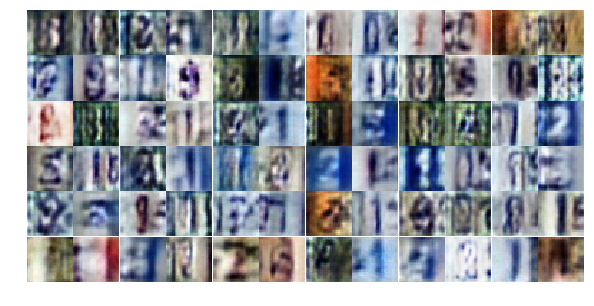

Epoch 4/10... Discriminator Loss: 0.5296... Generator Loss: 1.2227
Epoch 4/10... Discriminator Loss: 0.4238... Generator Loss: 1.9460
Epoch 4/10... Discriminator Loss: 0.3862... Generator Loss: 1.7625
Epoch 4/10... Discriminator Loss: 0.6428... Generator Loss: 1.9516
Epoch 4/10... Discriminator Loss: 0.6931... Generator Loss: 1.1766
Epoch 4/10... Discriminator Loss: 0.5869... Generator Loss: 1.5006
Epoch 4/10... Discriminator Loss: 0.3405... Generator Loss: 1.7448
Epoch 4/10... Discriminator Loss: 0.5839... Generator Loss: 1.2325


In [ ]:
# Load the data and train the network here
dataset = Dataset(trainset, testset)
losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

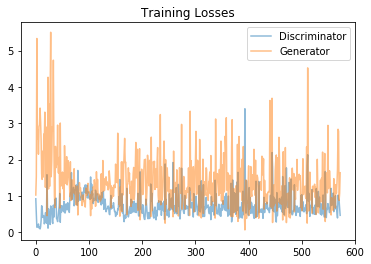

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

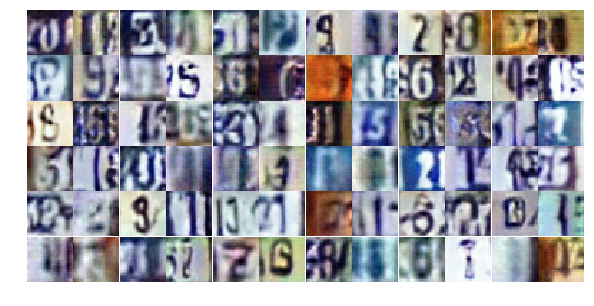

In [21]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))